<a href="https://colab.research.google.com/github/Marine27/TER/blob/master/utilitaires/Traitement_donnees_anae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traitement des données ANAE
---

Anaé est née le 24 juillet 2006. Elle a deux grands frères et est la dernière enfant de la famille. Sa mère est linguiste et son père est professeur d’anglais dans le secondaire. Anaé est une petite fille pétillante, têtue et pleine d’humour, qui partage une grande complicité avec sa maman. Aliyah Morgenstern et Marie Leroy la filment entre trente minutes et une heure par mois en situation naturelle depuis ses 1;04. Son développement langagier est assez rapide et Anaé fait preuve d’une grande créativité dans la construction de son langage, inventant ses propres règles notamment au niveau de la morphologie verbale ou du genre, parfois à l’encontre des explications de ses parents.

# Imports 

In [0]:
import os 
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.varmax import VARMAX

## Lecture fichier final

In [0]:
data_child = pd.read_csv('..\data\data_anae_final.csv',
                           sep = '\t',
                           encoding = 'utf-8',
                           index_col=False)

# On supprime la colonne qui duplique les index
data_child = data_child.drop(columns = 'Unnamed: 0')

In [0]:
data_child.head(10)

,enfant,age,type,seconde_debut,seconde_fin,contenu
ind,,,,,,
0,ANAE,1_04_20,AEL,0,3,Arthur # regarde mon pain au lait .
1,ANAE,1_04_20,MOT,1001,1002,oui ?
2,ANAE,1_04_20,CHI,1002,1003,maman .
3,ANAE,1_04_20,MOT,1003,1004,qu' est+ce+qu' y+a ?
4,ANAE,1_04_20,MOT,1004,1007,ça c'est à Ael cette sucette .
5,ANAE,1_04_20,AEL,1007,1008,on va partager .
6,ANAE,1_04_20,MOT,1008,1010,+< il te reste des bonbons ou pas ?
7,ANAE,1_04_20,CHI,1010,1010,maman .
8,ANAE,1_04_20,AEL,1010,1011,non .


In [0]:
data_child.shape
data_child=data_child.sort_values(by = ['age','seconde_debut']) 

data_child.head()
data_child['ind']=[ i for i in range(len(data_child))]
data_child= data_child.set_index('ind')

In [0]:
data_child['ind']=[ i for i in range(len(data_child))]
data_child= data_child.set_index('ind')

In [0]:
#data_child

On peut maintenant utiliser le fichier 'data_anae_final.csv' pour l'exploration de données.

# Exploration des données

---

Qu'elles sont les différents type de ligne ?

In [0]:
print(len(data_child['type'].unique()))

41


In [0]:
#((data_child['type']=='pho')*1).describe()

Il existe 41 types de ligne dans les fichiers Andrien :

In [0]:
print(data_child['type'].unique())

['AEL' 'MOT' 'CHI' 'ART' '+div+' 'interlocuteur' 'sit' 'com' 'pho' 'act'
 'xpnt' 'int' '-div-' 'add' 'FAT' 'OBS' 'VIS' 'xpol' 'ximi' 'imi' 'TOY'
 'gpx' 'xpt' 'UNK' 'exp' 'gls' 'sng' 'UNI' 'mor' 'npho' 'CAM' 'xpho' 'BOY'
 'FRI' 'ANO' 'AUN' 'UNC' 'YON' 'NOA' 'ADU' 'ADU2']


In [0]:
#list( (data_child['type']=='pho')*1 ).count(1)

In [0]:
#data_child['type'].where(data_child['type']=='pho').dropna()

In [0]:
#data_child.iloc[96880]

## Les phonèmes

Les lignes de type 'pho' correspondent à la traduction phonétique lorsu'Anaé s'exprime :
* Nous avons à disposition 18756 transcriptions phonétiques pour Anae 
* On distingue les premiers mots d'Adrien à l'âge de un an 4 mois et 20 jours
* Les traductions s'arrêtent à l'âge de 5 ans 7 mois et 06 jours

In [0]:
pho_child = data_child[data_child['type'] == 'pho']
#pho_child

In [0]:
data_child.replace(['START','END'],np.nan , inplace=True)
data_child[['seconde_debut','seconde_fin']].fillna(method='ffill',inplace=True)

In [0]:
#data_child

### Valeurs NaN

2 valeurs à lâcher 

In [0]:
#pho_child.loc[pho_child['contenu'].isna()]

,enfant,age,type,seconde_debut,seconde_fin,contenu,index,année,mois,jour


In [0]:
#Supprime les 2 lignes
pho_child = pho_child.dropna(subset=['type', 'contenu'])

In [0]:
#pho_child.drop([44550,44551],inplace=True)
pho_child['index']=[i for i in range(len(pho_child))]

In [0]:
#pho_child.set_index('index')

Nous allons chercher à visualiser la quantité phonétique de données à disposition

## Visualisation des données phonétiques

### Ajout des colonnes 'année', 'mois' et 'jour'

On considère que la colonne age a pout format : x_xx_xx (année_mois_jour) ainsi :
* ``pho_child['age'][0:1]`` nous donne le nombre d'année
* ``pho_child['age'][2:4]`` nous donne le nombre de mois
* ``pho_child['age'][5:7]`` nous donne le nombre de jours

In [0]:
#pho_child

In [0]:
# Ajout du nombre d'année
année_pho_child = pho_child.apply(lambda row: row['age'][0:1], axis=1)
pho_child['année'] = année_pho_child

# Ajout du nombre de mois
mois_pho_child = pho_child.apply(lambda row: row['age'][2:4], axis=1)
pho_child['mois'] = mois_pho_child

# Ajout du nombre de jour
jour_pho_child = pho_child.apply(lambda row: row['age'][5:7], axis=1)
pho_child['jour'] = jour_pho_child

In [0]:
#pho_child

## Quantité de données

Combien avons-nous de ligne pour chaque année ? mois ? jour ?

### Quantité de données par année

In [0]:
nb_phrase_annee = pho_child[{'année','contenu'}].groupby('année').count()
nb_phrase_annee.rename(columns={'contenu': 'nb_phrase'})

,nb_phrase
année,
1,2670
2,8235
3,4240
4,3032
5,577


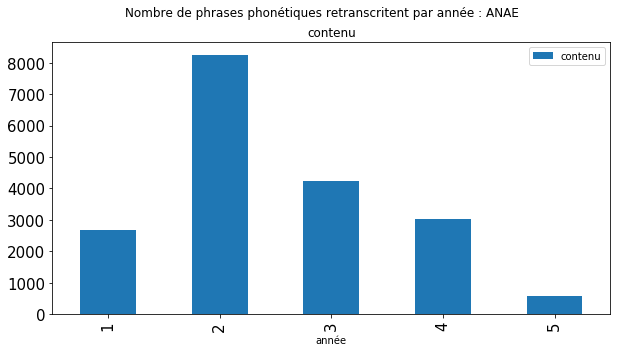

In [0]:
from matplotlib import pyplot as plt
nb_phrase_annee.plot(kind='bar', 
                       subplots=True, 
                       figsize=(10,5),
                       title = 'Nombre de phrases phonétiques retranscritent par année : ANAE',
                       fontsize = 15,
                       use_index = True) 
plt.show()

In [0]:
#len(pho_child.loc[pho_child['année'] == '5'])

On voit qu'il y a des quantités de données phonétiques différentes pour chaques années :
* Nous avons peu de données pour la première année (2670 lignes)
* Nous avons beaucoup de données la deuxième année (8237 lignes)
* Il y a de moins en moins de données la troisième puis la quatrième année (4240 puis 3032 lignes)
* Enfin nous avons très peu de données pour la cinquième année (577 lignes)

### Quantité de données par mois

Regardons plus en détail la quantité de données phonétiques par mois :

In [0]:
nb_phrase_mois = pho_child[{'année','mois','contenu'}].groupby(['année','mois']).count()
nb_phrase_mois = nb_phrase_mois.rename(columns={'contenu': 'nb_phrase'})
#nb_phrase_mois.unstack(level=1)

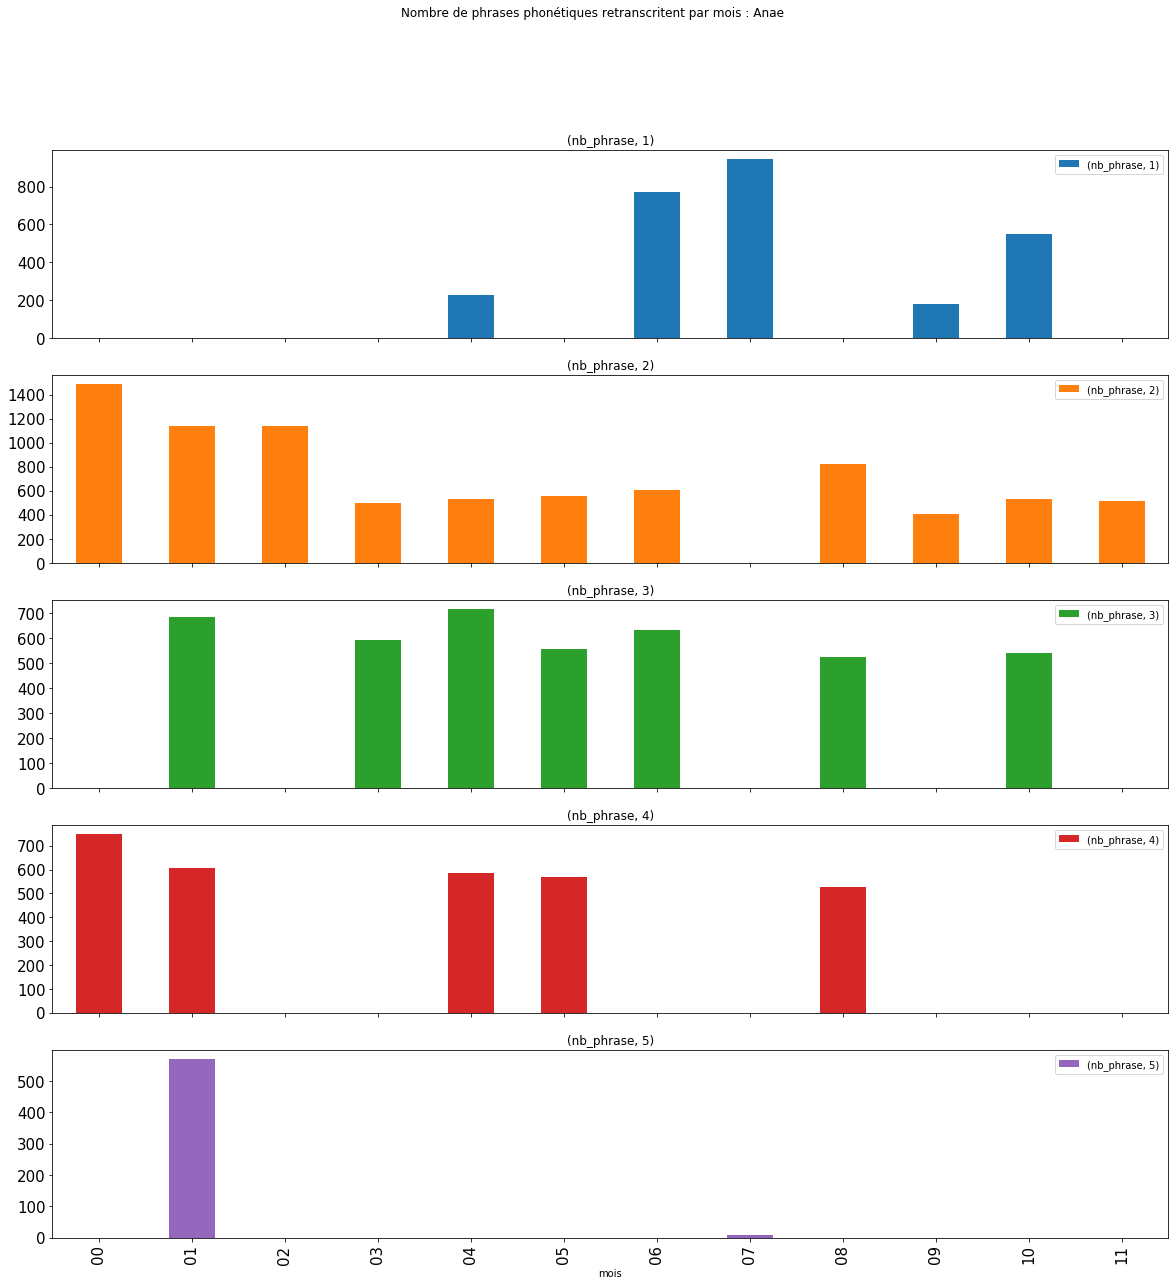

In [0]:
plt = nb_phrase_mois.unstack(level=0).plot(kind='bar', 
                                     subplots=True, 
                                     figsize=(20, 20),
                                     title = 'Nombre de phrases phonétiques retranscritent par mois : Anae',
                                     fontsize = 15,
                                     use_index = True)

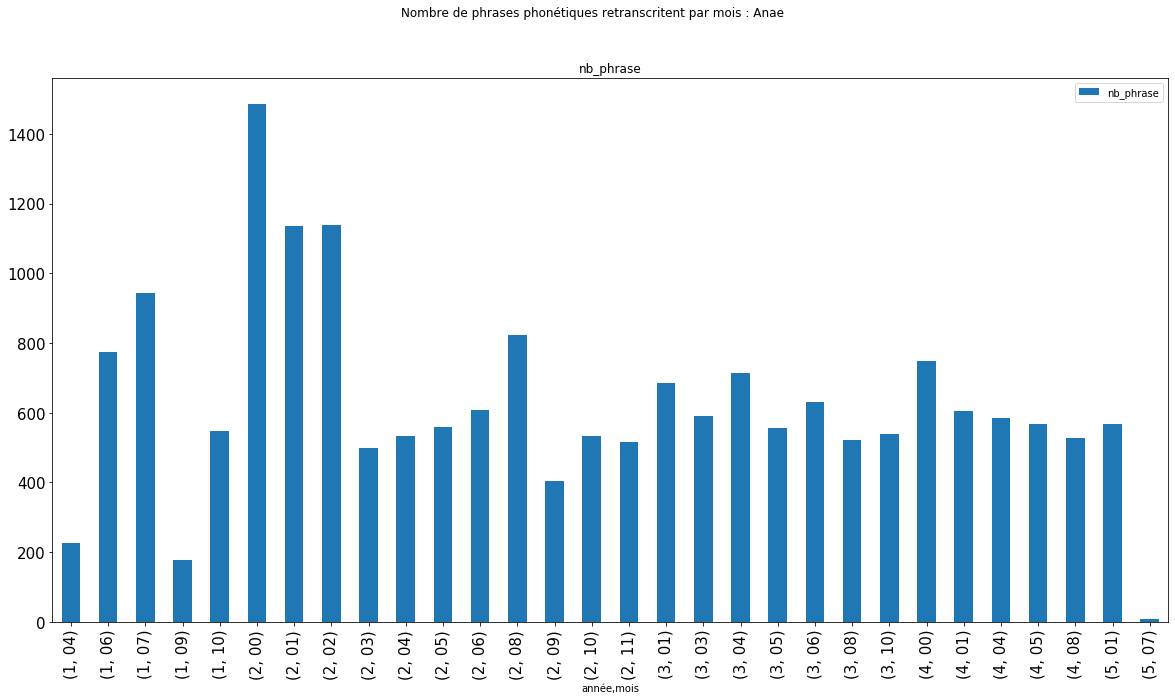

In [0]:
plt = nb_phrase_mois.plot(kind='bar',
                    subplots=True, 
                    figsize=(20, 10),
                    title = 'Nombre de phrases phonétiques retranscritent par mois : Anae',
                    fontsize = 15,
                    use_index = True)

### Quantité de données par jour

Regardons maintenant la quantité de données par jours :

In [0]:
nb_phrase_jour = pho_child[{'année','mois', 'jour', 'contenu'}].groupby(['année','mois', 'jour']).count()
nb_phrase_jour = nb_phrase_jour.rename(columns={'contenu': 'nb_phrase'})
#nb_phrase_jour

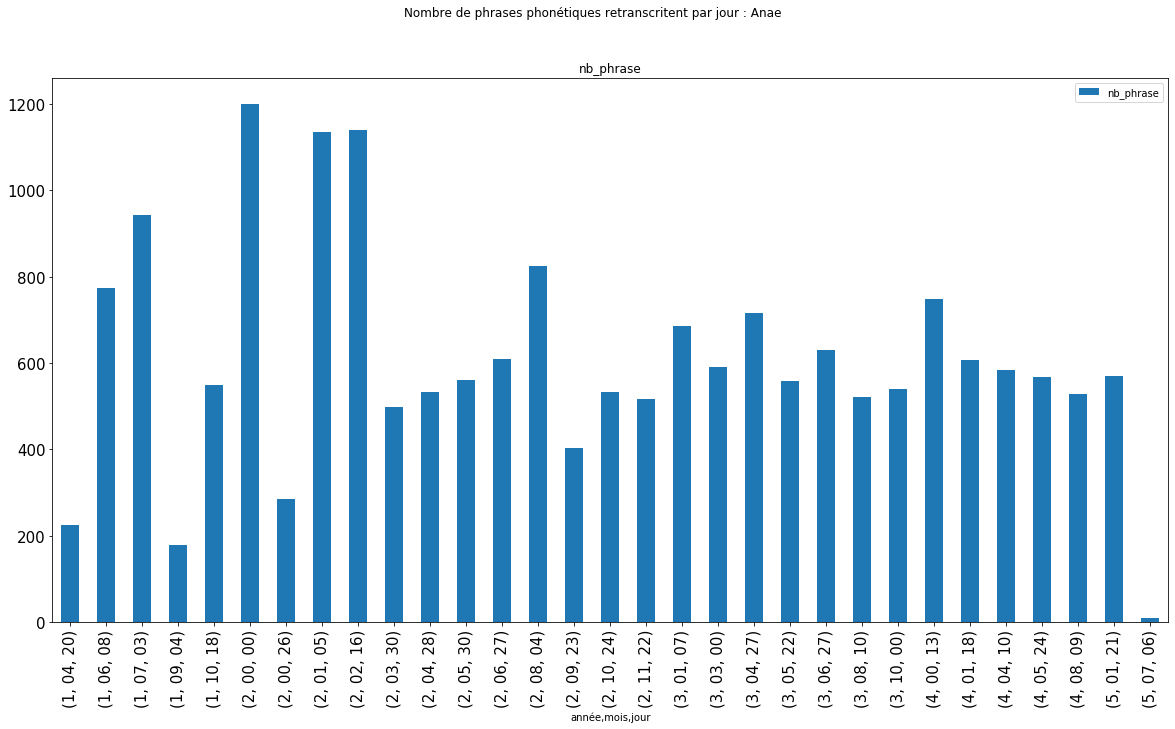

In [0]:
plt = nb_phrase_jour.plot(kind='bar',
                    subplots=True,
                    figsize=(20, 10),
                    title = 'Nombre de phrases phonétiques retranscritent par jour : Anae',
                    fontsize = 15,
                    use_index = True)

De cette manière la distribution de la quantité de données phonétique n'est pas continu. En effet nous avons découpé les données de tel sorte à avoir la quantité de données pour chaque retranscription d'Anaé. On remarque que les valeurs fluctues : il serait interressant d'observer de plus près pour connaitre les raisons de cette fluctuation : 

* Est-ce du à la durée d'enregistrement ?
* Est-ce du à un problème technique ?
* Est-ce du à l'enfant ?

De plus elle n'est pas distribué de manière équitable dans le temps. <br>
On peut difficelement mesurer la croissance du nombre de prise de parole (on pourrait croiser cette donnée avec la durée de l'enregistrement pour une meilleure mesure). <br>

On a maintenant une meilleure vision de la quantité de données phonétiques à disposition et de leur répartition dans le temps.

## Nombre de mot
Nous allons chercher à explorer le nombre de mot au sens phonétique par phrase. <br>
Pour cela on peut compter le nombre d'espace dans la chaîne de caractère :

In [0]:
#pho_child

In [0]:
# Exemple 
pho = pho_child.at[1000, 'contenu']
print('Nombre de mot dans "' + pho + '" : '+ str(pho.count(' ')+1))

Nombre de mot dans "e sa se kwa" : 4


Pour chaque ligne on calcul le nombre de mot phonétique :

In [0]:
nb_mot_pho = pho_child.apply(lambda row: row['contenu'].count(' ')+1, axis=1)
pho_child['nombre_mot_phonétique'] = nb_mot_pho #On ajoute une colonne contenant le nombre de mot

Par exemple on peut avoir la phrase de Julie avec le plus grand nombre de mot :

In [0]:
a = pho_child.loc[pho_child['nombre_mot_phonétique'] == pho_child['nombre_mot_phonétique'].max()].contenu.values
print(a)
print('longueur: '+str(str(a).count(' ')+1))

['me X dɑ̃ pətizami ja ja X e ja dɛ ʁɔlœʁ e ja yn vwatyʁ ki e ki e ki e ki e ki e ki e ki e dɑ̃z dɑ̃ də dəsy œ̃ naʁbʁ e e e apʁɛ ba ba X ba ba j avɛ j avɛ j avɛ kɛl javɛ ɛ̃ pətiammii ki ki ki a mi de zɛl a la vwatyʁ e ɛ s e ɛ e javɛ kɛlkɛ̃ ki metɛ ɛ̃ kusɛ̃ puʁ pa lɥi fɛʁ mal']
longueur: 81


Voici la ligne de cette phrase :

In [0]:
pho_child.loc[pho_child['nombre_mot_phonétique'] == 81 ]

,enfant,age,type,seconde_debut,seconde_fin,contenu,index,année,mois,jour,nombre_mot_phonétique
28214,ANAE,3_10_00,pho,NaN,NaN,me X dɑ̃ pətizami ja ja X e ja dɛ ʁɔlœʁ e ja y...,14850,3,10,00,81


### Espérance de mot par phrase

Il est intéressant d'observer le nombre de mot moyen que contient les phrases. C'est un indicateur qui peut nous aiguiller sur l'explosion du lexicale de l'enfant. 

In [0]:
mean_nb_mot_pho_jour = pho_child[{'année', 'mois', 'jour', 'nombre_mot_phonétique'}].groupby(['année', 'mois', 'jour']).mean()
mean_nb_mot_pho_jour = mean_nb_mot_pho_jour.rename(columns={'nombre_mot_phonétique': 'espérance_nombre_de_mot_phonétique'})
#mean_nb_mot_pho_jour

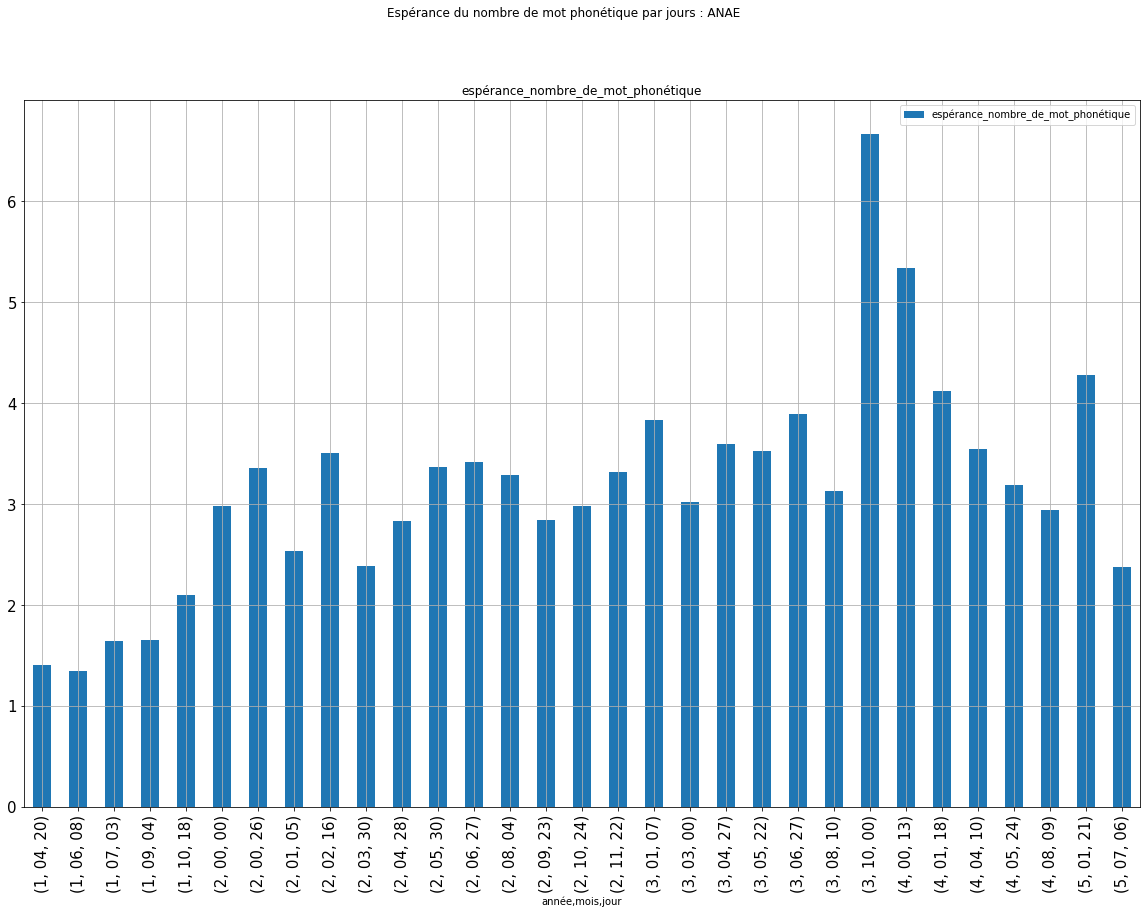

In [0]:
plt = mean_nb_mot_pho_jour.plot(kind='bar', 
                            subplots=True, 
                            figsize=(20, 13),
                            title = 'Espérance du nombre de mot phonétique par jours : ANAE',
                            fontsize = 15,
                            use_index = True,
                            grid=True)

De manière générale l'espérance du nombre de mot par phrase augmente.

### Variance du nombre de mot par phrase

In [0]:
var_nb_mot_pho_jour = pho_child[{'année','mois','jour', 'nombre_mot_phonétique'}].groupby(['année','mois', 'jour']).var()
var_nb_mot_pho_jour = var_nb_mot_pho_jour.rename(columns={'nombre_mot_phonétique': 'variance'})
#var_nb_mot_pho_jour

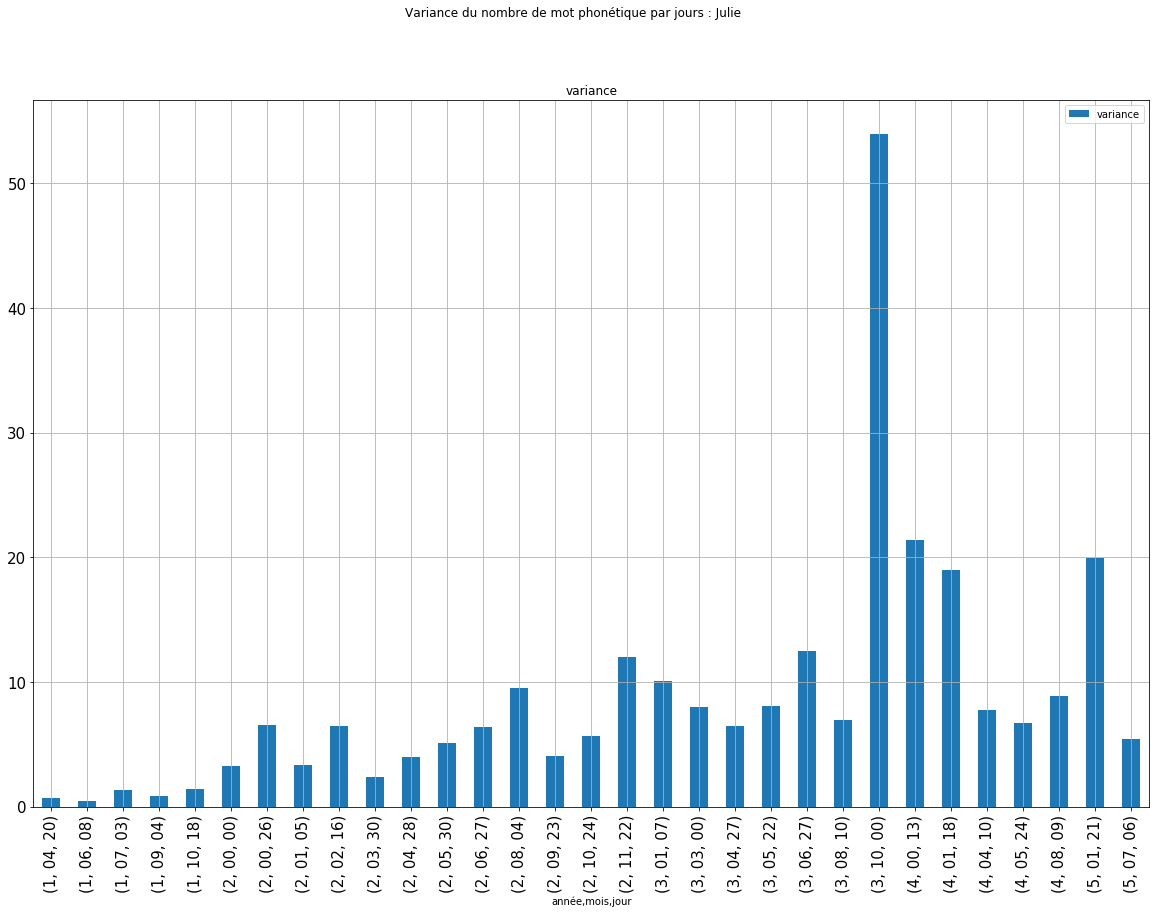

In [0]:
plt = var_nb_mot_pho_jour.plot(kind='bar', 
                            subplots=True, 
                            figsize=(20, 13),
                            title = 'Variance du nombre de mot phonétique par jours : Julie',
                            fontsize = 15,
                            use_index = True,
                            grid=True)

### Plus grande phrase 

In [0]:
max_mot_pho_child = pho_child[{'année','mois','jour', 'nombre_mot_phonétique'}].groupby(['année','mois','jour']).max()
max_mot_pho_child = max_mot_pho_child.rename(columns={'nombre_mot_phonétique': 'longueur_max'})
#max_mot_pho_child

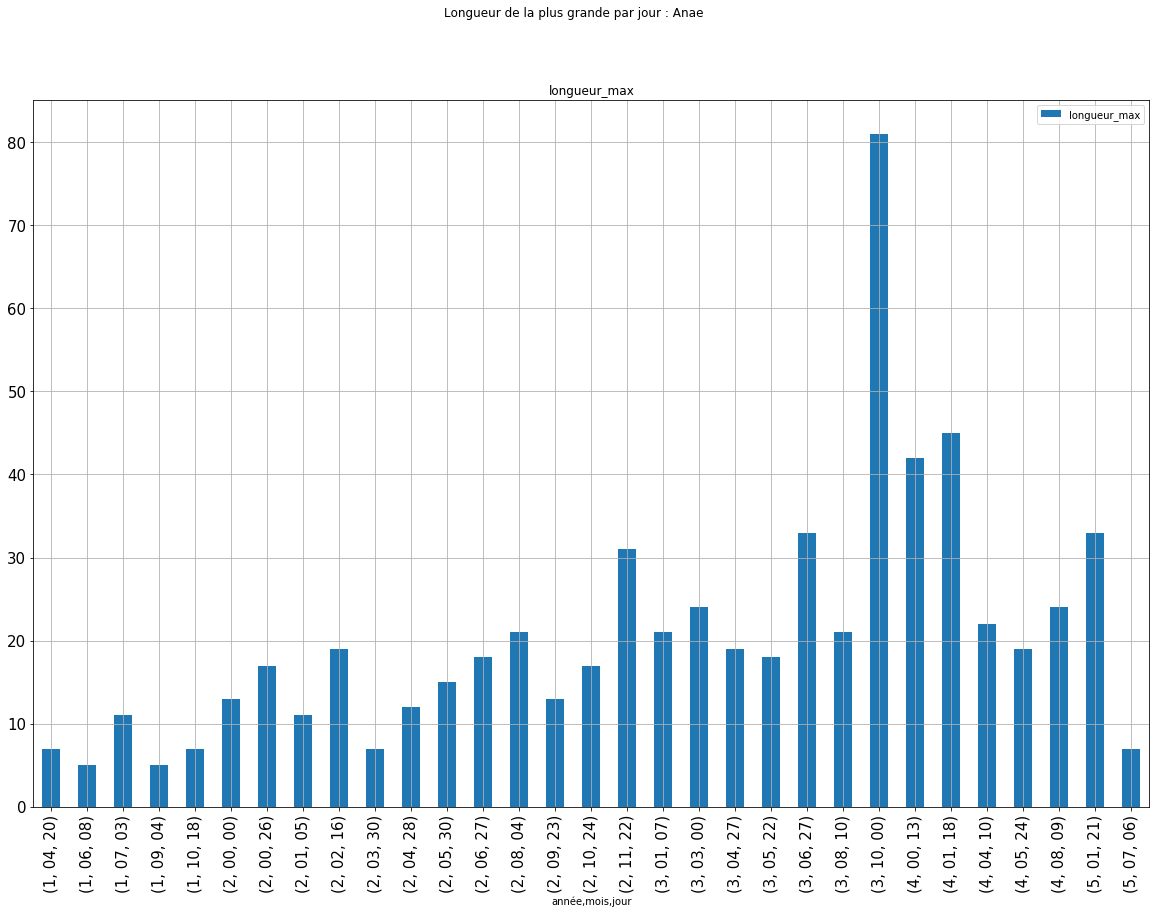

In [0]:
plt = max_mot_pho_child.plot(kind='bar', 
                            subplots=True, 
                            figsize=(20, 13),
                            title = 'Longueur de la plus grande par jour : Anae',
                            fontsize = 15,
                            use_index = True,
                            grid=True)

In [0]:
#Exemple: selection des phrases de 12 mots à l'age 2,xx,xx
#pho_child.loc[pho_child['année'] == '2'].loc[pho_child.loc[pho_child['année'] == '2']['nombre_mot_phonétique'] == 12]